### 1. Imports des modules

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

#CLASSIFIEURS
from sklearn import svm
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier

#CLUSTERING
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import ward_tree

from tqdm import tqdm_notebook as tqdm 


### 2. Lecture des données

In [27]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

In [30]:
smartwatch_df.head(5)

,index,source,timestamp,values
0,164349,battery,2017-06-29 07:45:56.262,['98']
1,164350,accelerometer,2017-06-29 07:46:01.263,"['-0.3440857', '0.68330383', '9.967361']"
2,164351,gravity,2017-06-29 07:46:01.324,"['-0.34131828', '0.6573288', '9.778641']"
3,164352,linear_acceleration,2017-06-29 07:46:01.329,"['-0.018068999', '0.034808993', '-0.033065796']"
4,164353,gyroscope,2017-06-29 07:46:01.402,"['0.0041656494', '-0.0132751465', '0.006164551']"


In [31]:
data = {}

data['battery'] = [None] * len(smartwatch_df)
data['pressure'] = [None] * len(smartwatch_df)
data['heart_rate'] = [None] * len(smartwatch_df)
data['step_counter'] = [None] * len(smartwatch_df)
data['step_detector'] = [None] * len(smartwatch_df)


for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    
    
    values = [ float(x) for x in ast.literal_eval(row['values']) ]

    if row['source'] == 'battery':
        data['battery'][index] = values[0]
    
    if row['source'] == 'pressure':
        data['pressure'][index] = values[0]

    if row['source'] == 'heart_rate':
        data['heart_rate'][index] = values[0]

    if row['source'] == 'step_counter':
        data['step_counter'][index] = values[0]

    if row['source'] == 'step_detector':
        data['step_detector'][index] = values[0]

smartwatch_df["battery"] = data['battery']
smartwatch_df["pressure"] = data['pressure']
smartwatch_df["heart_rate"] = data['heart_rate']
smartwatch_df["step_counter"] = data['step_counter']
smartwatch_df["step_detector"] = data['step_detector']

smartwatch_df = smartwatch_df[ 
                                smartwatch_df['battery'].notnull() | 
                                smartwatch_df['pressure'].notnull() | 
                                smartwatch_df['heart_rate'].notnull() | 
                                smartwatch_df['step_counter'].notnull() |  
                                smartwatch_df['step_detector'].notnull()
                             ]

smartwatch_df = smartwatch_df.set_index('timestamp')
smartwatch_df = smartwatch_df[['battery','pressure','heart_rate','step_counter','step_detector']]
smartwatch_df = smartwatch_df.resample('min').mean()
smartwatch_df['step_detector'].fillna(0.0, inplace=True)
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=200471), HTML(value='')))

,battery,pressure,heart_rate,step_counter,step_detector
timestamp,,,,,
2017-06-29 07:47:00,97.0,968.387418,111.095238,0.0,1.0
2017-06-29 07:48:00,97.0,969.122270,75.076923,3.0,1.0
2017-06-29 07:49:00,97.0,968.621508,68.076923,4.0,1.0
2017-06-29 07:53:00,96.0,968.427790,65.500000,14.0,1.0
2017-06-29 07:55:00,96.0,969.014685,69.500000,14.0,1.0


In [32]:
report_df.head()

,index,activity_type,duration,from,to,comment
0,0,Video games,01:43,2017-07-01 21:34:00,2017-07-01 23:17:00,NaN
1,1,In computer,00:03,2017-07-01 21:29:00,2017-07-01 21:32:00,NaN
2,2,At home,13:35,2017-07-01 21:13:00,2017-07-02 10:49:00,NaN
3,3,In computer,00:05,2017-07-01 21:08:00,2017-07-01 21:13:00,NaN
4,4,Eat,00:18,2017-07-01 20:49:00,2017-07-01 21:07:00,NaN


In [36]:
data = {}
data['activity_index'] = [None] * len(smartwatch_df)
data['activity_type'] = [None] * len(smartwatch_df)

i=0
for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
            data['activity_index'][i] = int(report_row['index'])
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

smartwatch_df["activity_index"] = data['activity_index']
smartwatch_df["activity_type"] = data['activity_type']
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=970), HTML(value='')))

,battery,pressure,heart_rate,step_counter,step_detector,activity_index,activity_type
timestamp,,,,,,,
2017-06-29 09:57:00,82.0,963.995217,76.083333,21.000,1.0,12.0,Eat
2017-06-29 10:02:00,81.0,963.848278,71.727273,11.125,1.0,12.0,Eat
2017-06-29 10:03:00,81.0,964.089400,91.750000,50.500,1.0,12.0,Eat
2017-06-29 10:04:00,81.0,965.504640,105.000000,98.000,1.0,12.0,Eat
2017-06-29 10:05:00,81.0,964.328500,109.666667,104.000,1.0,12.0,Eat


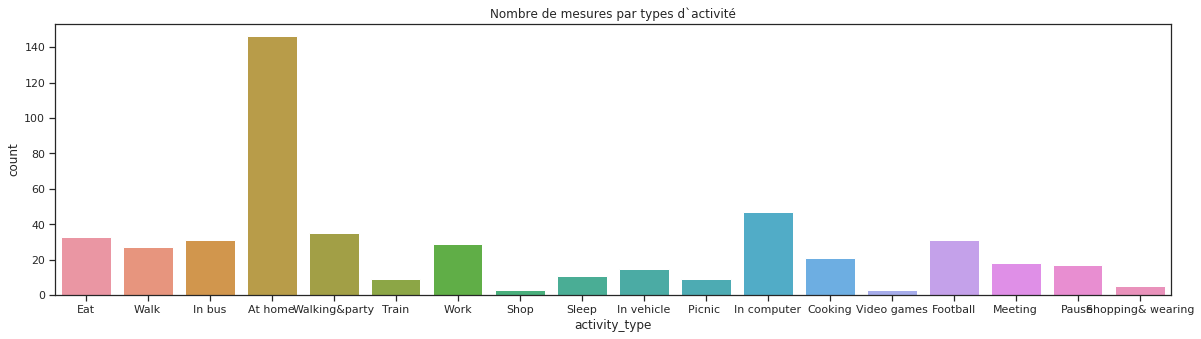

In [37]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=smartwatch_df).set_title('Nombre de mesures par types d`activité')

In [38]:
variables = ['battery', 'pressure', 'heart_rate', 'step_counter']

smartwatch_df[variables].describe()

,battery,pressure,heart_rate,step_counter
count,490.000000,490.000000,490.000000,490.000000
mean,49.727405,981.669030,83.229356,31.654034
std,26.767759,6.980682,23.349088,37.403447
min,4.000000,963.848278,47.600000,0.000000
25%,25.000000,976.540469,67.305582,6.000000
50%,52.000000,981.040198,76.992424,16.583333
75%,75.000000,987.902633,91.000000,42.500000
max,95.000000,998.251650,166.400000,167.000000


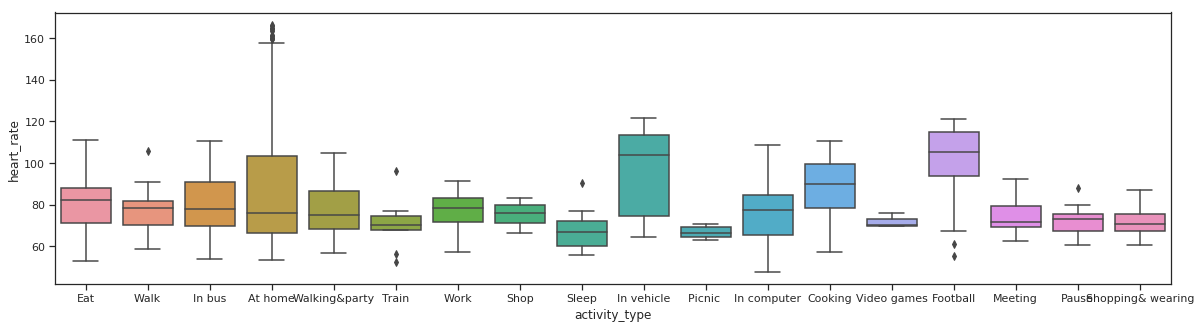

In [39]:
fig, ax = plt.subplots(figsize=(20,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="heart_rate", data=smartwatch_df)

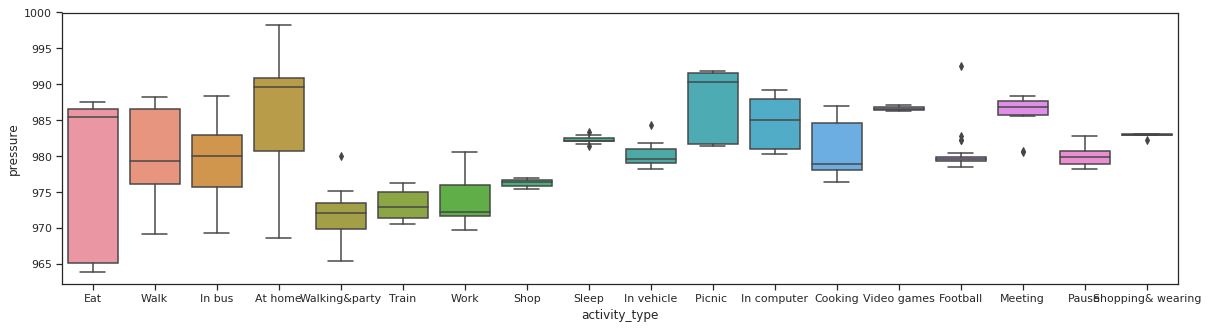

In [40]:
fig, ax = plt.subplots(figsize=(20,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="pressure", data=smartwatch_df)

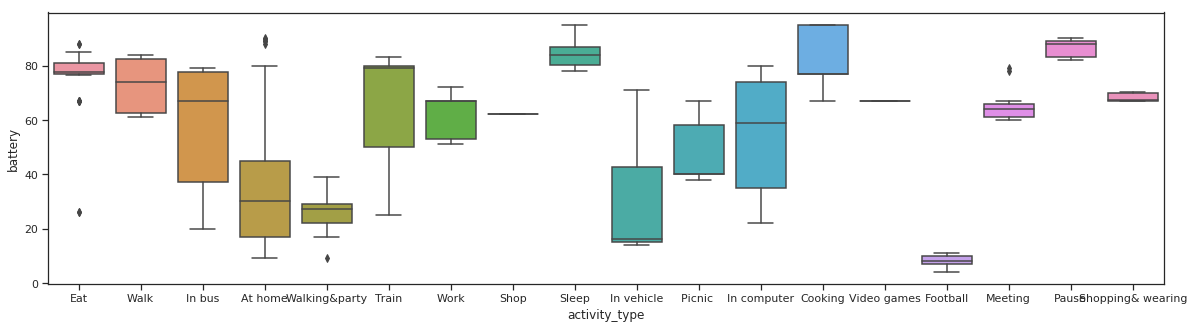

In [41]:
fig, ax = plt.subplots(figsize=(20,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="battery", data=smartwatch_df)

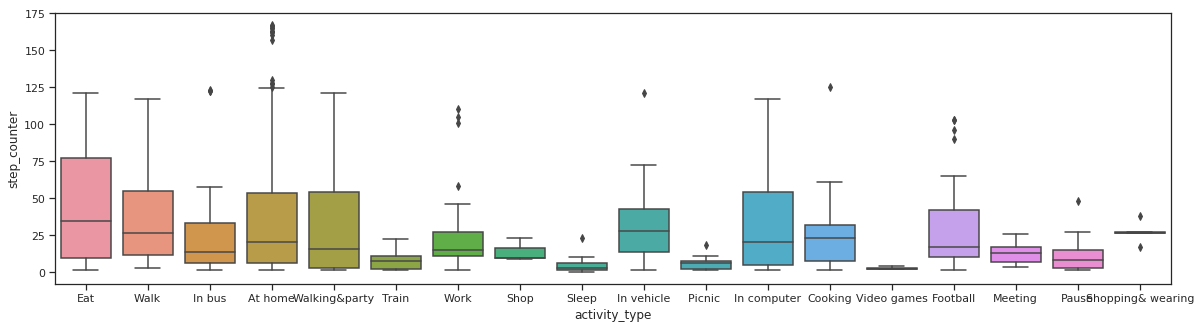

In [42]:
fig, ax = plt.subplots(figsize=(20,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="step_counter", data=smartwatch_df)

### 2. Clustering

In [90]:
variables = [
#     'battery', 
#     'pressure', 
    'heart_rate', 
    'step_counter'
]

# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(smartwatch_df[variables])
smartwatch_df_normal = normal_scaler_fit.transform(smartwatch_df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(smartwatch_df_normal, columns=variables)

y = smartwatch_df['activity_type']

### 4.  Corrélations

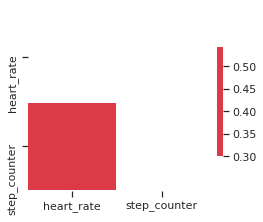

In [91]:
# Matrice de correlation
corr = X.corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 4.  Analyse par Composantes Principales

IndexError: index 2 is out of bounds for axis 1 with size 2

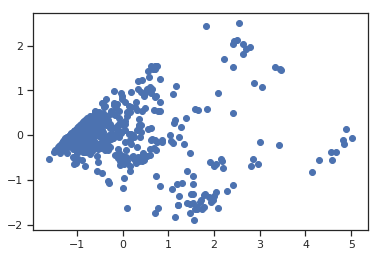

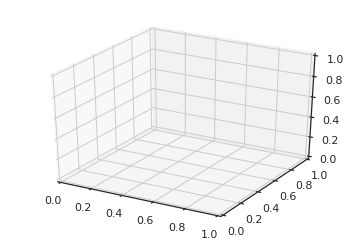

In [93]:
n_components = 2
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

### 5. Classification

#### Sans l'ACP:

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [95]:
names = [
    "Nearest Neighbors",
    "Decision Tree", 
]

classifiers = [
    KNeighborsClassifier(1),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.21
Nearest Neighbors cross-validated scores: 
[0.16167665 0.18787879 0.19620253]




Decision Tree score: 0.29
Decision Tree cross-validated scores: 
[0.29341317 0.2969697  0.30379747]




#### Avec l'ACP:

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=101)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.67
Nearest Neighbors cross-validated scores: 
[0.38922156 0.62424242 0.36075949]




Linear SVM score: 0.35
Linear SVM cross-validated scores: 
[0.30538922 0.3030303  0.36708861]




Decision Tree score: 0.44
Decision Tree cross-validated scores: 
[0.28143713 0.52727273 0.28481013]




### 5. Clustering

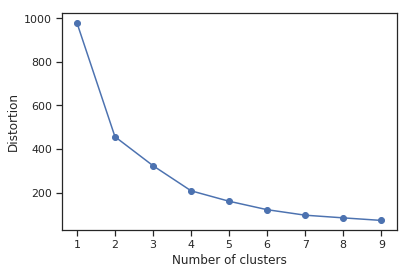

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

distortions = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [97]:
km_n_clusters_ = 2
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X_train)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)
prediction_k_means = kmeans.fit_predict(X_test)
centers_km

,heart_rate,step_counter
0,-0.319662,-0.427674
1,1.103571,1.707400


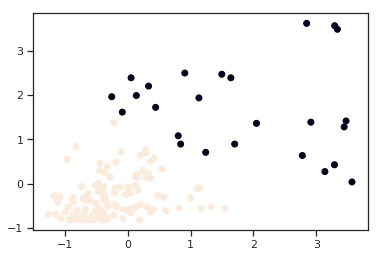

In [99]:
fig = plt.figure()

# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.scatter(X_test['heart_rate'],  X_test['step_counter'], c=prediction_k_means)
plt.show()